## Methodology

- Train an autoencoder on all of the data available to be able to reconstruct any image with an identity
- accrue an average representation of all of the vangogh images in the latent space of this autoencoder
- accrue an average representation of all NON vangogh images in the latent space of the autoencoder

- v1
    - find the common values between all vangogh images and then take a weighted sum between that and the latent space of an arbitrary image
- v2
    - find the difference between the average vangogh image and the average image and then take a weighted sum between that and the latent space of an arbitrary image

In [1]:
import os
import PIL
import time
import random
import imageio
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import matplotlib.pyplot as pt

from glob import glob
from tqdm import tqdm
from skimage.transform import resize
from typing import Iterable, List, Tuple, Any

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

## Dataset
- Train: 8868 images
- Test: 1697

In [4]:
data_dir = 'data'
random_image_dir = os.path.join(data_dir, 'random_images')
vangogh_image_dir = os.path.join(data_dir, 'vangogh_images')

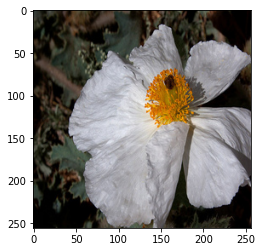

In [5]:
pt.imshow(load_random_image(random_image_dir, "*.jpg"))

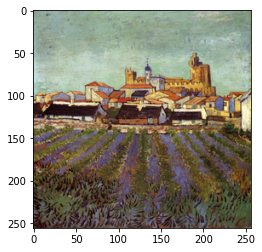

In [6]:
pt.imshow(load_random_image(vangogh_image_dir, "*.jpg"))

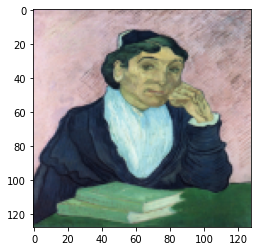

In [7]:
pt.imshow(resize(load_random_image(vangogh_image_dir, "*.jpg"), (128, 128, 3)))

In [5]:
BATCH_SIZE = 64
BUFFER_SIZE = 512
DATASET_SIZE = len(list_files(random_image_dir, "*.jpg")) + len(list_files(vangogh_image_dir, "*.jpg"))

In [6]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.95, 1.2),
    validation_split = 0.2,
)

gen_params = dict(
    target_size       =  (256, 256),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  'binary',
)

In [7]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

train_gen = dgen.flow_from_directory(
    data_dir, 
    subset="training",
    **gen_params,
)

val_gen = dgen.flow_from_directory(
    data_dir, 
    subset="validation",
    **gen_params,
)

Found 16263 images belonging to 3 classes.
Found 4065 images belonging to 3 classes.


In [8]:
train_ds = tfd.Dataset.from_generator(lambda: train_gen, (tf.float32, tf.int32))
val_ds = tfd.Dataset.from_generator(lambda: val_gen, (tf.float32, tf.int32))

[1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


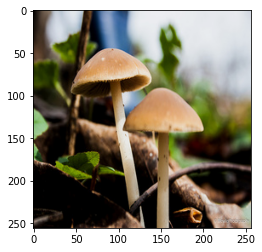

In [12]:
for img, label in train_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


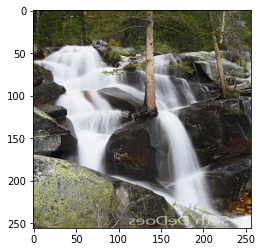

In [13]:
for img, label in val_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

## At this point, we know that our train and val generators contain our images which are labeled 1 for a random image and 2 for a vangogh image

In [49]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, UpSampling2D, BatchNormalization, MaxPool2D, Dense, Reshape, LeakyReLU, Dropout, Flatten, Add

def downsampler_unit(input_tensor, num_features, filter_shape, strides_shape, padding, bias, max_pooling: bool = False):
    layer1 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    layer3 = BatchNormalization()(layer2)
    if max_pooling: 
        layer3 = MaxPool2D((2, 2))(layer3)
    layer3 = LeakyReLU()(layer3)

    return tf.keras.models.Model(inputs=input_tensor, outputs=layer3)

def upsampler_unit(input_tensor, scaling, filter_shape, strides_shape, padding, bias, batch_norm: bool = False):
    layer1 = UpSampling2D(strides_shape, interpolation='nearest')(input_tensor)
    layer2 = Conv2DTranspose(scaling, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    layer3 = Conv2DTranspose(scaling, filter_shape, strides=(1, 1), padding=padding, use_bias=bias)(layer2)
    if batch_norm:
        layer3 = BatchNormalization()(layer3)
    layer3 = LeakyReLU()(layer3)
    
    return tf.keras.models.Model(inputs=input_tensor, outputs=layer3)

def latent_space_unit(input_tensor, latent_dim, dropout_pct):
    latent_space = Dense(latent_dim)(input_tensor)

    return tf.keras.models.Model(inputs=input_tensor, outputs=latent_space)

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.multiplier = 2
        self.latent_dim = 256*self.multiplier

        self.encoder_input = Input(shape=(256, 256, 3))
        print(tuple(self.encoder_input.get_shape()))
        self.ds1 = downsampler_unit(self.encoder_input, 128, (7, 7), (1, 1), 'same', False, True)
        print(self.ds1.output_shape)
        self.ds2 = downsampler_unit(Input(shape=self.ds1.output_shape[1:]), 128, (3, 3), (2, 2), 'same', True, False)
        print(self.ds2.output_shape)
        self.ds3 = downsampler_unit(Input(shape=self.ds2.output_shape[1:]), 128, (3, 3), (2, 2), 'same', True, False)
        print(self.ds3.output_shape)

        self.latent_space = latent_space_unit(Input(shape=(np.prod(self.ds3.output_shape[1:]),)), self.latent_dim, 0.3)
        
        self.decoder_input = Input(shape=(8, 8, 4*self.multiplier))
        self.up1 = upsampler_unit(self.decoder_input, 256, (2, 2), (1, 1), 'same', True, True)
        print(self.up1.output_shape)
        self.up2 = upsampler_unit(Input(shape=self.up1.output_shape[1:]), 128, (3, 3), (2, 2), 'same', True, True)
        print(self.up2.output_shape)
        self.up3 = upsampler_unit(Input(shape=self.up2.output_shape[1:]), 3, (3, 3), (2, 2), 'same', True, False)
        print(self.up3.output_shape)
        
    def plot_model_graph(self):
        tf.keras.utils.plot_model(
            tf.keras.models.Model(
                inputs=self.encoder_input, 
                outputs=self.call(self.encoder_input)), 
            'functional_components.png', 
            expand_nested=True, 
            show_shapes=True)
    
    def encode(self, image_batch, training: bool = False):
        layer1 = self.ds1(image_batch)
        layer2 = self.ds2(layer1)
        layer3 = self.ds3(layer2)
        dense_in = Flatten()(layer3)
        if training:
            dense_in = Dropout(0.3)(dense_in)

        latent_space = self.latent_space(dense_in)
        
        return latent_space, layer2
    
    def decode(self, latent_space, skip_layer):
        reshape = Reshape((8, 8, 4*self.multiplier))(latent_space)
        layer4 = self.up1(reshape)
        layer5 = self.up2(layer4)
        layer5 = Add()([skip_layer, layer5])
        layer6 = self.up3(layer5)
        
        return layer6

    def call(self, image_batch, training: bool = False):
        latent_space, skip_layer = self.encode(image_batch, training)
        return self.decode(latent_space, skip_layer)


In [50]:
autoencoder = Autoencoder()

(None, 256, 256, 3)
(None, 128, 128, 128)
(None, 32, 32, 128)
(None, 8, 8, 128)
(None, 8, 8, 256)
(None, 32, 32, 128)
(None, 128, 128, 3)


In [51]:
autoencoder.build(input_shape=(BATCH_SIZE, 256, 256, 3))
autoencoder.summary()

Model: "autoencoder_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_108 (Functional)       (None, 128, 128, 128)     822144    
_________________________________________________________________
model_109 (Functional)       (None, 32, 32, 128)       295680    
_________________________________________________________________
model_110 (Functional)       (None, 8, 8, 128)         295680    
_________________________________________________________________
model_111 (Functional)       (None, 512)               4194816   
_________________________________________________________________
model_112 (Functional)       (None, 8, 8, 256)         271872    
_________________________________________________________________
model_113 (Functional)       (None, 32, 32, 128)       443136    
_________________________________________________________________
model_114 (Functional)       (None, 128, 128, 3)    

In [52]:
autoencoder.plot_model_graph()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [53]:
mse = tf.keras.losses.MSE

In [55]:
def autoencoder_loss(original_image, decoded_image):
    return mse(original_image, decoded_image)

In [56]:
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=2e-4)

C:\Users\miked\anaconda3\envs\python_base\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [57]:
checkpoint_dir: str = 'autoencoder_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    autoencoder=autoencoder,
                                )

In [58]:
EPOCHS = 1
EPOCH_BATCHES = 1000

In [71]:
@tf.function
def train_step(images):
    loss = None
    with tf.GradientTape() as grad:
        autoencoded_images = autoencoder(images, training=True)
        print(images.shape)
        loss = autoencoder_loss(resize(images, (BATCH_SIZE, 128, 128, 3)), autoencoded_images)
    gradients_of_autoencoder = grad.gradient(loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
    
    return loss

In [72]:
def train(images, epochs, epoch_batches, img):
    with tqdm(total=epochs*epoch_batches) as pbar:
        for epoch in range(epochs):
            start = time.time()
#             x = np.linspace(0, epoch_batches, epoch_batches)
#             losses = []
            for image, _ in images.take(epoch_batches):
#                 loss = tf.math.reduce_mean(tf.math.reduce_sum(train_step(image)))
#                 losses.append(loss)
                pbar.update(1)
            if (epoch+1) % 5 == 0:
#                 checkpoint.save(file_prefix=checkpoint_prefix)
                print(f'loss for epoch {epoch} : {loss}')
                autoencoder.save('high_level_skip_connection2', save_format='tf')
                pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])
                pt.savefig(f'epoch_output/{epoch}.png')
#                 pt.plot(x, losses, 'bo')
#                 pt.show()
        print(f"Time for epoch {epoch} is {time.time()-start}")

In [11]:
im  = []
for img, _ in train_ds.take(10).as_numpy_iterator():
    im.append(img[0, ...].reshape(1, *img[0,...].shape))

In [74]:
train(train_ds, EPOCHS, EPOCH_BATCHES, im[0])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:56<00:00,  5.65it/s]

Time for epoch 0 is 176.96188712120056


In [ ]:
# for img, _ in train_ds.take(1).as_numpy_iterator():
#     pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])

In [75]:
autoencoder.save('high_level_skip_connection2', save_format='tf')

INFO:tensorflow:Assets written to: high_level_skip_connection2\assets


In [ ]:
# newauto = tf.keras.models.load_model('model_200')

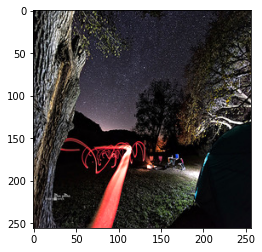

In [76]:
pt.imshow(im[0][0, ...])

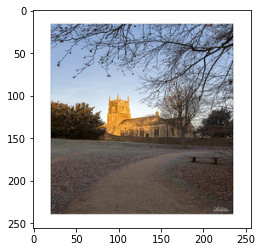

In [77]:
pt.imshow(im[2][0, ...])

In [81]:
pt.imshow(autoencoder(im[0][0, ...].reshape(1, 128, 128, 3))[0, ...])

ValueError: cannot reshape array of size 196608 into shape (1,128,128,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


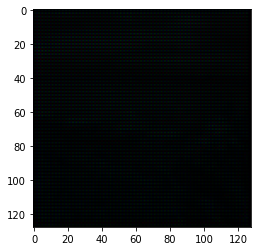

In [79]:
pt.imshow(autoencoder(im[1][0, ...].reshape(1, *im[0][0,...].shape))[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


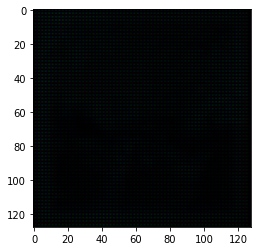

In [80]:
enc1, ski1 = autoencoder.encode(im[0][0, ...].reshape(1, *im[0][0,...].shape))
enc2, ski2 = autoencoder.encode(im[2][0, ...].reshape(1, *im[0][0,...].shape))

output = autoencoder.decode(enc1, (ski1 + ski2) * 0.5).numpy()
pt.imshow(output.reshape(*output[0, ...].shape))

In [ ]:
output = autoencoder.decode((enc1+enc2)/2, (ski1+0.5*ski2)/1.5).numpy()
pt.imshow(output.reshape(*output[0, ...].shape))

In [9]:
auto = tf.keras.models.load_model('high_level_skip_connection')

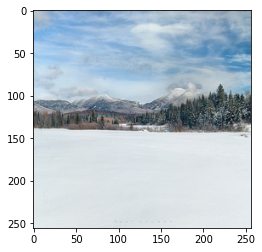

In [12]:
pt.imshow(im[0][0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


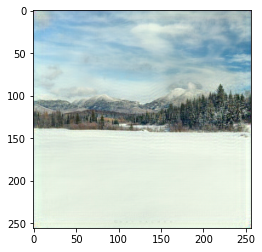

In [13]:
pt.imshow(auto(im[0])[0, ...])

In [14]:
base_images = np.zeros_like([im[0][0, ...]])
style_images = np.zeros_like([im[0][0, ...]])
print(base_images.shape)
num_b = 1
with tqdm(total=num_b) as pbar:
    for img, label in train_ds.take(num_b).as_numpy_iterator():
        print(label)
        print(img.shape)
        for image, image_label in zip(img, label):
            print(image.shape)
            if image_label == 2: 
                style_images = np.concatenate([style_images, image.reshape(1, *image.shape)], axis=0)
            if image_label == 1: 
                base_images = np.concatenate([base_images, image.reshape(1, *image.shape)], axis=0)
        pbar.update(1)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(1, 256, 256, 3)
[1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(64, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [15]:
base_images = base_images[1:, ...]
style_images = style_images[1:, ...]

In [16]:
base_images.shape

(62, 256, 256, 3)

In [17]:
style_images.shape

(2, 256, 256, 3)

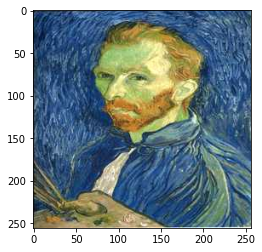

In [18]:
pt.imshow(style_images[0, ...])

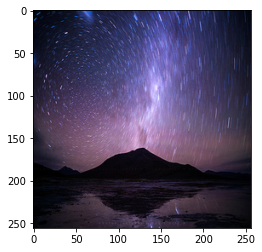

In [19]:
pt.imshow(base_images[0, ...])

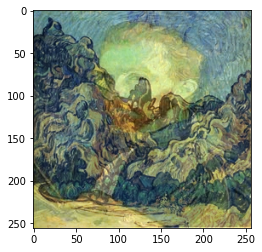

In [20]:
# average styled image
pt.imshow(np.average(style_images, axis=0))

In [23]:
print(auto)

In [25]:
# now doing it through our autoencoder
output = auto.encode(style_images[0])
print(output.shape)

AttributeError: 'Autoencoder' object has no attribute 'encode'